In [1]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pymc3 as pm
import scipy
from scipy.integrate import quad
from itertools import cycle

plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
df = pd.read_csv('../csvs/Kepler-23_stability.csv', index_col=0)
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing,spockprob
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True,0.010296
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False,0.787886
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False,0.009134
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False,0.005355
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False,0.014513


In [3]:
def calcHPDI(vals, interval, guess, weights=None):
    '''
    Fit a gaussian KDE, find max likelihood, and calculate 
    minimum interval that holds `interval` percentage of the distribution.
    This is what Hadden 2017 quote

        vals : array of values
        interval: float for size of interval
        guess: initial guess for max likelihood
    '''
    vals = np.concatenate([vals, vals*(-1)]) # reflect values to negative to avoid edge effects at zero
    try:
        weights=np.concatenate([weights, weights])
    except:
        pass
    
    kde = scipy.stats.gaussian_kde(vals, bw_method=1/15, weights=weights)
    maxlike = scipy.optimize.fmin(lambda x: -kde(x), x0=guess, disp=False)[0]
    
    sample = kde.resample(10000, seed=0) # need to do this step in case we need to weight the vals by weights (for SPOCK probs)
    samplecut = sample[sample > 0]

    low, high = pm.stats.hpd(samplecut, credible_interval=interval)
    return kde, maxlike, high, low

In [4]:
def plot(ax, df, col, xlabel, lim=1, labels=False):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    _ = next(colors) # skip color to match other plots
    
    Nbins=20
    
    sample1e4 = df[(df['spockprob']>0)&(df['crossing']==False)]
    label = "$10^4$ N-body Orbits\n" if labels else ""
    vals, edges = np.histogram(sample1e4[col], density=True, bins=np.linspace(0,lim,Nbins))
    
    kde, maxlike, high, low = calcHPDI(sample1e4[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    ax.bar(edges[:-1], vals, width=np.diff(edges), fc='gray', alpha=0.5, label=label, ec='', align='edge')

    nbody = df[(df['nbodystable']==1)]
    label = "$10^9$ N-body Orbits\n" if labels else ""
    vals, edges = np.histogram(nbody[col], density=True, bins=edges)
    
    kde, maxlike, high, low = calcHPDI(nbody[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    ax.bar(edges[:-1], vals, width=np.diff(edges), fc=next(colors), alpha=0.5, label=label, ec='', align='edge')

    _ = next(colors) # skip color to match other plots
    _ = next(colors) # skip color to match other plots
    
    spock = df[df['crossing']==False]
    label = "SPOCK\n" if labels else ""
    vals, edges = np.histogram(spock[col], density=True, bins=edges, weights=spock.spockprob)
    
    kde, maxlike, high, low = calcHPDI(spock[col], interval=0.683, guess=0.1, weights=spock.spockprob)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    
    ax.bar(edges[:-1], vals, width=np.diff(edges), fc=next(colors), alpha=0.5, label=label, ec='', align='edge')

    ax.set_xlabel(xlabel)
    ax.set_xlim([0,lim])

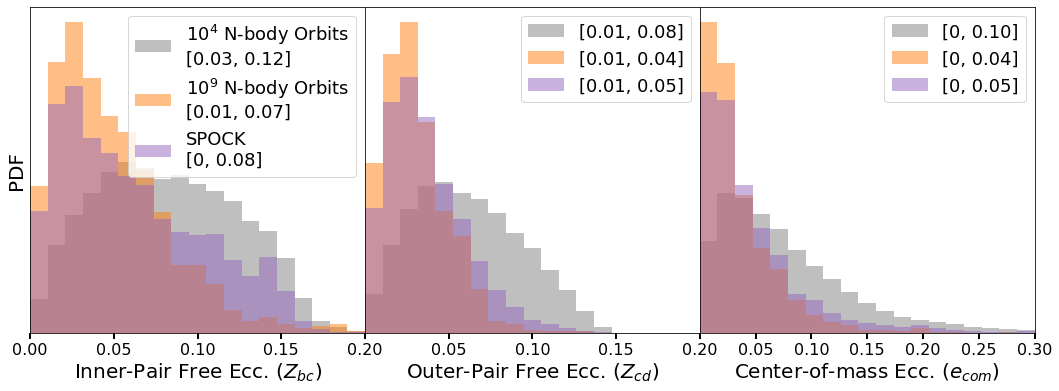

In [5]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)

plot(axarr[0], df, 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', labels=True, lim=0.2)
plot(axarr[1], df, 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', lim=0.2)
plot(axarr[2], df, 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', lim=0.3)

for ax in axarr.flatten():
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[1].set_xticks([0.05,0.1,0.15,0.2])
axarr[2].set_xticks([0.05,0.1,0.15,0.2, 0.25, 0.3])
axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')